In [ ]:

from pyspark.sql import SparkSession

# # Tạo (hoặc lấy) SparkSession
spark = SparkSession.builder.appName("RFMAnalysis").getOrCreate()

# Đọc trực tiếp file CSV đã làm sạch
retail_sdf = spark.read.csv ('/content/df_cleaned.csv',
    header=True,          # dòng đầu là tên cột
    inferSchema=True      # tự suy đoán kiểu dữ liệu
)

# Kiểm tra nhanh
retail_sdf.printSchema()
retail_sdf.show(5)


root
 |-- Invoice: integer (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: integer (nullable = true)
 |-- Country: string (nullable = true)

+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|Customer ID|       Country|
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
| 489434|    85048|15CM CHRISTMAS GL...|      12|2009-12-01 07:45:00| 6.95|      13085|United Kingdom|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|      13085|United Kingdom|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|      13085|United Kingdom|
| 489434|    22041|"RECORD FRAME 7""...|     

In [ ]:
from pyspark.sql.functions import max, datediff, countDistinct, sum as Fsum, col
import pyspark.sql.functions as F

# Ngày phân tích
snapshot_date = retail_sdf.agg(max("InvoiceDate")).collect()[0][0]

rfm_df = retail_sdf.groupBy("Customer ID").agg(
    datediff(
        F.lit(snapshot_date), max("InvoiceDate")
    ).alias("Recency"),
    countDistinct("Invoice").alias("Frequency"),
    Fsum(col("Quantity") * col("Price")).alias("Monetary")
)

rfm_df.head(5)

[Row(Customer ID=15957, Recency=31, Frequency=3, Monetary=930.0999999999999),
 Row(Customer ID=16861, Recency=59, Frequency=5, Monetary=946.5900000000001),
 Row(Customer ID=15447, Recency=330, Frequency=5, Monetary=492.88),
 Row(Customer ID=17389, Recency=0, Frequency=61, Monetary=57224.67999999999),
 Row(Customer ID=14450, Recency=180, Frequency=7, Monetary=1128.4399999999998)]

In [ ]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

# 1. VectorAssembler
assembler = VectorAssembler(
    inputCols=["Recency", "Frequency", "Monetary"],
    outputCol="features_raw")
assembled = assembler.transform(rfm_df)

# 2. MinMaxScaler
scaler = MinMaxScaler(inputCol="features_raw", outputCol="features")
scaler_model = scaler.fit(assembled)
scaled_data = scaler_model.transform(assembled)


THỬ NGHIỆM


In [ ]:
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

wssse_list = []

for k in range(2, 11):
    kmeans = KMeans(featuresCol="features", k=k, seed=42)
    model = kmeans.fit(scaled_data)
    wssse = model.summary.trainingCost
    wssse_list.append((k, wssse))
    print(f"k = {k}, WSSSE = {wssse:.2f}")


k = 2, WSSSE = 100.99
k = 3, WSSSE = 52.10
k = 4, WSSSE = 30.04
k = 5, WSSSE = 23.95
k = 6, WSSSE = 19.61
k = 7, WSSSE = 16.44
k = 8, WSSSE = 12.06
k = 9, WSSSE = 10.95
k = 10, WSSSE = 9.73


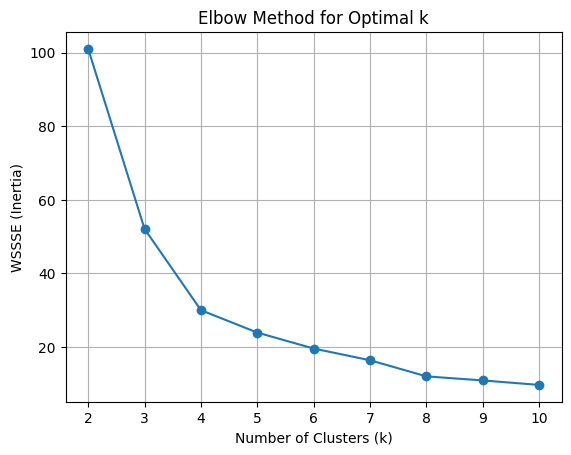

In [ ]:
x, y = zip(*wssse_list)
plt.plot(x, y, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WSSSE (Inertia)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

# Chuyển danh sách về numpy array
ks = np.array(x)
costs = np.array(y)

# Hai điểm đầu và cuối
point1 = np.array([ks[0], costs[0]])
point2 = np.array([ks[-1], costs[-1]])

# Tính khoảng cách vuông góc từ mỗi điểm đến đường nối point1 - point2
def perpendicular_distance(point, line_start, line_end):
    return np.abs(np.cross(line_end - line_start, line_start - point)) / np.linalg.norm(line_end - line_start)

distances = [perpendicular_distance(np.array([ks[i], costs[i]]), point1, point2) for i in range(len(ks))]

# Tìm vị trí có khoảng cách lớn nhất → điểm gãy
elbow_index = int(np.argmax(distances))
best_k = ks[elbow_index]
print(f"Best k by Elbow Method = {best_k}")


Best k by Elbow Method = 4


<ipython-input-42-75cce8636d58>:13: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, line_start - point)) / np.linalg.norm(line_end - line_start)


In [ ]:

from pyspark.ml import Pipeline

# Gắn vào Pipeline cuối cùng
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=int(best_k), seed=42)
pipeline = Pipeline(stages=[assembler, scaler, kmeans])
model = pipeline.fit(rfm_df)
clustered_df = model.transform(rfm_df)

In [ ]:
#Xem kết quả
clustered_df.select("Customer ID", "Recency", "Frequency", "Monetary", "cluster").show(10)
# Hiển thị thông tin mô tả (mean, median, etc.) cho từng cụm
print(f"Thống kê mô tả cho từng cụm với k = {best_k}:")
clustered_df.groupBy("cluster").agg(
    F.mean("Recency").alias("Avg_Recency"),
    F.mean("Frequency").alias("Avg_Frequency"),
    F.mean("Monetary").alias("Avg_Monetary"),
    F.count("*").alias("Cluster_Size")
).orderBy("cluster").show()


+-----------+-------+---------+------------------+-------+
|Customer ID|Recency|Frequency|          Monetary|cluster|
+-----------+-------+---------+------------------+-------+
|      18196|     95|        4|1462.3900000000003|      2|
|      13723|    217|        6|1209.2000000000003|      3|
|      13452|    259|        3|             729.8|      3|
|      17499|    289|        2|1341.3899999999999|      3|
|      16742|    492|       13|           2387.71|      0|
|      15057|    275|        5|3255.9599999999996|      3|
|      17048|    117|        7|2071.6800000000003|      2|
|      17043|     32|        8|2616.5499999999997|      2|
|      15194|      3|       28|12427.690000000002|      2|
|      12568|    644|        1|              70.0|      1|
+-----------+-------+---------+------------------+-------+
only showing top 10 rows

Thống kê mô tả cho từng cụm với k = 4:
+-------+------------------+------------------+-----------------+------------+
|cluster|       Avg_Recency|  

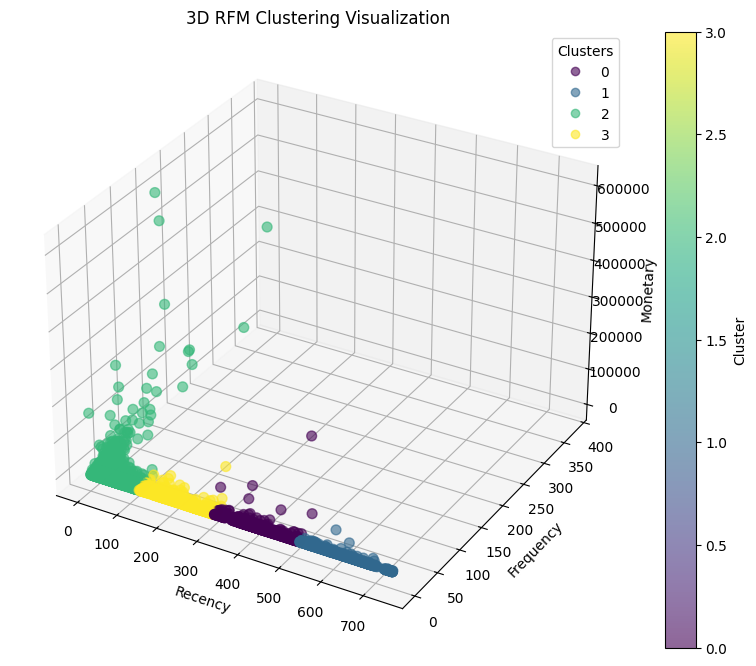

In [ ]:
# prompt: biểu diễn phân cụm 3 chiều

# Chuyển Spark DataFrame sang Pandas DataFrame để vẽ biểu đồ
clustered_pandas_df = clustered_df.select("Recency", "Frequency", "Monetary", "cluster").toPandas()

# Vẽ biểu đồ 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Sử dụng cluster làm màu sắc cho các điểm
scatter = ax.scatter(
    clustered_pandas_df['Recency'],
    clustered_pandas_df['Frequency'],
    clustered_pandas_df['Monetary'],
    c=clustered_pandas_df['cluster'], # Màu sắc theo cluster
    cmap='viridis',                     # Bảng màu
    s=50,                               # Kích thước điểm
    alpha=0.6                           # Độ trong suốt
)

# Đặt tên cho các trục
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D RFM Clustering Visualization')

# Thêm chú thích màu sắc (legend)
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
plt.colorbar(scatter, label='Cluster') # Thêm color bar

plt.show()


In [ ]:
import os
import shutil
clustered_df.select("Customer ID", "Recency", "Frequency", "Monetary", "cluster") \
    .coalesce(1) \
    .write.csv("data/output/clustered_df", header=True, mode="overwrite")

output_dir = "data/output/clustered_df"
final_path = "data/output/Ket_qua_phan_cum.csv"

# Tìm file bắt đầu bằng part- và kết thúc bằng .csv
for file_name in os.listdir(output_dir):
    if file_name.startswith("part-") and file_name.endswith(".csv"):
        shutil.move(os.path.join(output_dir, file_name), final_path)
        break

# (Không bắt buộc) Xoá thư mục gốc nếu muốn
shutil.rmtree(output_dir)

In [ ]:

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
import pyspark.sql.functions as F
import os
import shutil


# Ensure SparkSession is created with the JAR
spark = SparkSession.builder \
    .appName("IsolationForestExample") \
    .config("spark.jars", "jars/spark-iforest_2.11-0.1.0.jar") \
    .getOrCreate()

# Access the Java/Scala IsolationForest class via SparkContext's JVM gateway
IsolationForest = spark.sparkContext._jvm.com.linkedin.spark.ml.tree.IsolationForest

In [ ]:
from pyspark.sql import SparkSession, functions as F
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import pandas as pd
from pyspark.sql.functions import max, datediff, countDistinct, sum as Fsum, col
import pyspark.sql.functions as F

# Tạo Spark session
spark = SparkSession.builder.appName("SklearnIsolationForest").getOrCreate()

# Ví dụ: DataFrame đã có RFM
df = spark.read.csv("/content/df_cleaned.csv", header=True, inferSchema=True)

# Ngày phân tích
snapshot_date = df.agg(max("InvoiceDate")).collect()[0][0]

rfm_df = df.groupBy("Customer ID").agg(
    datediff(
        F.lit(snapshot_date), max("InvoiceDate")
    ).alias("Recency"),
    countDistinct("Invoice").alias("Frequency"),
    Fsum(col("Quantity") * col("Price")).alias("Monetary")
)

rfm_df.head(5)

# # Bước 1: Chọn dữ liệu cần phân tích
# rfm_data = df.select("Customer ID", "Recency", "Frequency", "Monetary")

# Bước 2: Chuyển Spark DataFrame → Pandas
rfm_pd = rfm_df.dropna().toPandas()

# Bước 3: Scale dữ liệu bằng StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(rfm_pd[["Recency", "Frequency", "Monetary"]])

# Bước 4: Chạy Isolation Forest
isoforest = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)
rfm_pd["anomaly"] = isoforest.fit_predict(scaled_features)
rfm_pd["anomaly_score"] = isoforest.decision_function(scaled_features)

# Gán nhãn: -1 là bất thường, 1 là bình thường
rfm_pd["anomaly"] = rfm_pd["anomaly"].map({1: 0, -1: 1})  # 1 = bất thường

# Bước 5: Chuyển lại Spark DataFrame nếu cần
df_anomaly = spark.createDataFrame(rfm_pd)

# Xem top 10 khách hàng bất thường
df_anomaly.filter("anomaly == 1").select("Customer ID", "anomaly_score").show()


+-----------+--------------------+
|Customer ID|       anomaly_score|
+-----------+--------------------+
|      17389|-0.11653326934861896|
|      12471|-0.09875141847319668|
|      13468|-0.03153693353814502|
|      17677| -0.0829755567064091|
|      15633|-0.00331344735277...|
|      16839|-0.02669899626819605|
|      14160|-0.03548451206342...|
|      16684|-0.14752622798916393|
|      16553|-0.03874064105462...|
|      13081|-0.06758719533674828|
|      14096|-0.05190747208111435|
|      17448|-0.10995273509742787|
|      17811|-1.10587272937445...|
|      12709|-0.02900216441663428|
|      13694|-0.18475879894870806|
|      15856|-0.07609034705546469|
|      14606|-0.12345894764356402|
|      13098|-0.00209909688834...|
|      18102|-0.19085671853794295|
|      12980|-0.00901289222468...|
+-----------+--------------------+
only showing top 20 rows



In [ ]:
df_anomaly.orderBy("anomaly_score").show(10)


+-----------+-------+---------+------------------+-------+--------------------+
|Customer ID|Recency|Frequency|          Monetary|anomaly|       anomaly_score|
+-----------+-------+---------+------------------+-------+--------------------+
|      14911|      1|      379| 284592.9699999999|      1| -0.1953201614148805|
|      14646|      1|      151| 528602.5199999997|      1| -0.1930854200738863|
|      14156|      9|      151| 305767.9199999998|      1|-0.19197031535154985|
|      18102|      0|      145| 608821.6499999997|      1|-0.19085671853794295|
|      13694|      3|      143|196482.81000000006|      1|-0.18475879894870806|
|      15311|      0|      207|116476.15999999997|      1|-0.18255260165851595|
|      13089|      2|      203|         116737.86|      1| -0.1798032381461453|
|      15061|      3|      127|137817.06999999995|      1|-0.17433233534588222|
|      16029|     38|      107|122209.14000000003|      1|-0.17433233534588222|
|      17850|    372|      155| 56600.08

In [ ]:
# prompt: cho thấy tất cả các khách hàng có anomaly bằng 1

df_anomaly.filter(df_anomaly.anomaly == 1).show()

+-----------+-------+---------+------------------+-------+--------------------+
|Customer ID|Recency|Frequency|          Monetary|anomaly|       anomaly_score|
+-----------+-------+---------+------------------+-------+--------------------+
|      17389|      0|       61| 57224.67999999999|      1|-0.11653326934861896|
|      12471|      2|       76| 39873.79000000001|      1|-0.09875141847319668|
|      13468|      1|       72|          13390.51|      1|-0.03153693353814502|
|      17677|      1|       54|          36692.91|      1| -0.0829755567064091|
|      15633|    509|       13| 4352.459999999999|      1|-0.00331344735277...|
|      16839|      8|       44|          22310.49|      1|-0.02669899626819605|
|      14160|    610|        7|           8421.47|      1|-0.03548451206342...|
|      16684|      4|       55|147142.77000000002|      1|-0.14752622798916393|
|      16553|    163|       33|16644.010000000002|      1|-0.03874064105462...|
|      13081|     11|       28| 59205.14

In [ ]:
# prompt: đếm số lượng khách hàng có anomaly bằng 1

# Đếm số lượng khách hàng có anomaly bằng 1
anomaly_count = df_anomaly.filter(df_anomaly.anomaly == 1).count()

print(f"Số lượng khách hàng có anomaly = 1 là: {anomaly_count}")

Số lượng khách hàng có anomaly = 1 là: 118


In [ ]:
# prompt: thống kê mô tả khách hàng có anomaly bằng 1

# Lọc DataFrame để chỉ lấy các khách hàng có anomaly = 1
anomaly_customers_df = df_anomaly.filter(df_anomaly.anomaly == 1)

# Hiển thị thống kê mô tả cho nhóm khách hàng anomaly
print("\nThống kê mô tả cho khách hàng có anomaly = 1:")
anomaly_customers_df.describe().show()


Thống kê mô tả cho khách hàng có anomaly = 1:
+-------+------------------+-----------------+-----------------+------------------+-------+--------------------+
|summary|       Customer ID|          Recency|        Frequency|          Monetary|anomaly|       anomaly_score|
+-------+------------------+-----------------+-----------------+------------------+-------+--------------------+
|  count|               118|              118|              118|               118|    118|                 118|
|   mean|15251.330508474577|            101.0|60.73728813559322| 56263.37934745763|    1.0|-0.07134428651859054|
| stddev|1783.9313833297508|187.6095235677905|58.78011000971225| 86282.31685117523|    0.0| 0.05614340041380116|
|    min|             12346|                0|                1|2995.5400000000004|      1| -0.1953201614148805|
|    max|             18251|              691|              379| 608821.6499999997|      1|-1.10587272937445...|
+-------+------------------+-----------------+---

In [ ]:

# Đếm số lượng khách hàng có anomaly bằng 1
anomaly_count = df_anomaly.filter(df_anomaly.anomaly == 0).count()

print(f"Số lượng khách hàng có anomaly = 0 là: {anomaly_count}")

Số lượng khách hàng có anomaly = 0 là: 5745


In [ ]:
# prompt: cho xem dideemr của 15957

customer_id_to_check = 15957

# Lọc DataFrame anomaly_customers_df để tìm thông tin của khách hàng có ID 15957
customer_info = df_anomaly.filter(df_anomaly["Customer ID"] == customer_id_to_check)

# Kiểm tra xem khách hàng có tồn tại trong DataFrame đã lọc hay không
if customer_info.count() > 0:
  print(f"Thông tin điểm anomaly của khách hàng {customer_id_to_check}:")
  customer_info.show()
else:
  print(f"Không tìm thấy thông tin điểm anomaly cho khách hàng {customer_id_to_check}.")


Thông tin điểm anomaly của khách hàng 15957:
+-----------+-------+---------+-----------------+-------+------------------+
|Customer ID|Recency|Frequency|         Monetary|anomaly|     anomaly_score|
+-----------+-------+---------+-----------------+-------+------------------+
|      15957|     31|        3|930.0999999999999|      0|0.2454821007187996|
+-----------+-------+---------+-----------------+-------+------------------+



In [ ]:
from pyspark.sql import SparkSession, functions as F
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

def create_spark_session(app_name="SklearnIsolationForest"):
    """Khởi tạo SparkSession"""
    return SparkSession.builder.appName(app_name).getOrCreate()

def load_data(spark, file_path):
    """Load dữ liệu từ CSV vào Spark DataFrame"""
    return spark.read.csv(file_path, header=True, inferSchema=True)

def calculate_rfm(df):
    """Tính các chỉ số RFM từ dữ liệu giao dịch"""
    snapshot_date = df.agg(F.max("InvoiceDate")).collect()[0][0]
    rfm_df = df.groupBy("Customer ID").agg(
        F.datediff(F.lit(snapshot_date), F.max("InvoiceDate")).alias("Recency"),
        F.countDistinct("Invoice").alias("Frequency"),
        F.sum(F.col("Quantity") * F.col("Price")).alias("Monetary")
    )
    return rfm_df.dropna()

def rfm_to_pandas(rfm_df):
    """Chuyển Spark DataFrame sang Pandas DataFrame"""
    return rfm_df.toPandas()

def scale_features(df_pd, features=["Recency", "Frequency", "Monetary"]):
    """Scale dữ liệu RFM với StandardScaler"""
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df_pd[features])
    return scaled, scaler

def run_isolation_forest(scaled_features, contamination=0.02, random_state=42):
    """Chạy Isolation Forest để phát hiện anomalies"""
    model = IsolationForest(n_estimators=100, contamination=contamination, random_state=random_state)
    preds = model.fit_predict(scaled_features)
    scores = model.decision_function(scaled_features)
    return preds, scores, model

def add_anomaly_results(df_pd, preds, scores):
    """Thêm cột anomaly và anomaly_score vào DataFrame Pandas"""
    df_pd["anomaly"] = preds
    df_pd["anomaly_score"] = scores
    return df_pd

def pandas_to_spark(spark, df_pd):
    """Chuyển Pandas DataFrame sang Spark DataFrame"""
    return spark.createDataFrame(df_pd)

def get_anomaly_threshold(df_anomaly):
    """Lấy ngưỡng anomaly_score thấp nhất của nhóm anomaly"""
    threshold = df_anomaly.filter("anomaly == -1").select(F.min("anomaly_score")).collect()[0][0]
    return threshold

def count_anomalies(df_anomaly):
    """Đếm số lượng anomaly và tổng số khách hàng, tính tỷ lệ"""
    num_anomalies = df_anomaly.filter("anomaly == -1").count()
    total_customers = df_anomaly.count()
    anomaly_ratio = (num_anomalies / total_customers) * 100  # phần trăm
    return num_anomalies, total_customers, anomaly_ratio

def show_anomalies(df_anomaly, top_n=10):
    """Hiển thị top N khách hàng bất thường"""
    print(f"Top {top_n} khách hàng bất thường:")
    df_anomaly.filter("anomaly == -1").select("Customer ID", "Recency", "Frequency", "Monetary", "anomaly_score")\
        .orderBy(F.asc("anomaly_score")).show(top_n, truncate=False)

def main(file_path):
    spark = create_spark_session()
    df = load_data(spark, file_path)
    rfm_df = calculate_rfm(df)
    rfm_pd = rfm_to_pandas(rfm_df)
    scaled_features, scaler = scale_features(rfm_pd)
    preds, scores, model = run_isolation_forest(scaled_features)
    rfm_pd = add_anomaly_results(rfm_pd, preds, scores)
    df_anomaly = pandas_to_spark(spark, rfm_pd)

    threshold = get_anomaly_threshold(df_anomaly)
    print(f"Ngưỡng anomaly_score để bị coi là bất thường: {threshold}")

    num_anomalies, total_customers, anomaly_ratio = count_anomalies(df_anomaly)
    print(f"Số lượng khách hàng bất thường: {num_anomalies}")
    print(f"Tổng số khách hàng: {total_customers}")
    print(f"Tỷ lệ khách hàng bất thường: {anomaly_ratio:.2f}%")

    show_anomalies(df_anomaly)

    return df_anomaly

if __name__ == "__main__":
    file_path = "/content/df_cleaned.csv"
    main(file_path)


AnalysisException: [PATH_NOT_FOUND] Path does not exist: file:/content/df_cleaned.csv.